# Naive Bayes (Gaussiano)

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import metrics
import numpy as np
import pandas as pd

In [2]:
SCORINGS = ["roc_auc", "accuracy", "precision", "recall", "f1"]
METRIC = "roc_auc"

def metrics_table(model, X, Y):
    predicted = model.predict(X)
    probabilities = model.predict_proba(X)[:,1]
    
    roc_auc = metrics.roc_auc_score(Y, probabilities)
    f1 = metrics.f1_score(Y, predicted)
    acc = metrics.accuracy_score(Y, predicted)
    rec = metrics.recall_score(Y, predicted)
    prec = metrics.precision_score(Y, predicted)
    return pd.DataFrame.from_dict({
        "AUC-ROC": [roc_auc], "Accuracy": [acc], "Precision": [prec], "Recall": [rec], "F1 Score": [f1]
    })

## Modelo inicial

Algo a considerar es que Gaussian Naive Bayes contempla más que nada variables continuas. Para este primer modelo, por ahora, vamos a probar a dejar las numéricas que son discretas (nubosidad), pero en este modelo no vamos a utilizar la feature de "barrio" que es de clasificación.

In [41]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
drop_categoricas(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

pipe = iterative_imputer()

In [42]:
X_grid = pipe.fit_transform(X_train)
grid = GridSearchCV(GaussianNB(), param_grid = {'var_smoothing': [10**x for x in range(-16, 1)]},
                    verbose = 1, n_jobs = -1, cv = StratifiedKFold(3), scoring = SCORINGS, refit = METRIC)

grid.fit(X_grid, Y_train.values.ravel())

grid.best_score_

Fitting 3 folds for each of 17 candidates, totalling 51 fits


0.8334890268601732

In [43]:
tabla = pd.DataFrame(grid.cv_results_)
tabla['param_var_smoothing'] = tabla['param_var_smoothing'].map('{:.3e}'.format)
tabla.sort_values("rank_test_" + METRIC, inplace = True)
tabla.reset_index(inplace = True)
cols = ["param_var_smoothing"] + ["mean_test_" + x for x in SCORINGS]
tabla[cols]

,param_var_smoothing,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,1.000e-08,0.833489,0.819140,0.598119,0.583652,0.590797
1,1.000e-07,0.832009,0.831098,0.696321,0.434476,0.535070
2,1.000e-09,0.831865,0.801844,0.549380,0.635142,0.589156
3,1.000e-10,0.831333,0.798791,0.542281,0.644589,0.589022
4,1.000e-11,0.831234,0.798485,0.541606,0.645353,0.588942
5,1.000e-12,0.831222,0.798375,0.541391,0.645244,0.588769
6,1.000e-13,0.831220,0.798400,0.541437,0.645299,0.588819
7,1.000e-15,0.831220,0.798400,0.541437,0.645299,0.588819
8,1.000e-16,0.831220,0.798400,0.541437,0.645299,0.588819
9,1.000e-14,0.831220,0.798400,0.541437,0.645299,0.588819


El modelo que mejor resultó es el de smoothing del orden de $10^{-8}$, asi que vamos a usar ese valor para entrenar a los modelos. 

In [44]:
pipe.steps.append(['nb', GaussianNB(var_smoothing = 1e-8)])

pipe.fit(X_train, Y_train.values.ravel())

metrics_table(pipe, X_test, Y_test.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.835237,0.819621,0.603851,0.572858,0.587946


Validando con el set de test, el AUC-ROC dio 0.835 y el accuracy 82%, lo cual no es para tanto considerando que podría conseguir alrededor de 77% diciendo siempre no, como pasó con los últimos de la tabla del grid search. Ni el recall ni el precision son muy buenos.

## Dropeando features correlacionadas

En el dataset hay variables fuertemente correlacionadas, lo cual va en contra de las asunciones que hace Naive Bayes. Vamos a probar a dropear algunas de las variables que tenían más alta covarianza con otras y entrenar nuevamente. De todas formas, esto puede dar resultados bastante malos ya que algunas de estas relaciones nos sirvieron al menos en la baseline.

In [45]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
drop_correlacionadas(df_features) # lo nuevo
drop_categoricas(df_features)

# Son los mismos sets, tienen el mismo random state
X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

pipe = iterative_imputer()

In [46]:
pipe.steps.append(['nb', GaussianNB(var_smoothing = 1e-8)])

pipe.fit(X_train, Y_train.values.ravel())

metrics_table(pipe, X_test, Y_test.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.835992,0.82221,0.614139,0.561114,0.58643


Mejoró un poco el accuracy, precision y AUC-ROC pero empeoró el recall aún más. Una idea mejor podría ser hacer un Forward Selection en vez de sacar las features a ojo, lo cual hacemos un poco más adelante.

## Sin features discretas

Podemos probar a sacar también las features discretas, siendo que al utilizar el Gaussiano considera mejor las continuas y quizás estan perjudicando al modelo.

In [47]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
drop_discretas(df_features) # lo nuevo
drop_categoricas(df_features)

# Son los mismos sets, tienen el mismo random state
X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.35, random_state = 123)

pipe = iterative_imputer()

In [48]:
pipe.steps.append(['nb', GaussianNB(var_smoothing = 1e-8)])

pipe.fit(X_train, Y_train.values.ravel())

metrics_table(pipe, X_test, Y_test.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.82949,0.823781,0.625185,0.526875,0.571836


Parece que no ayudó mucho, aumentó el accuracy pero las demás métricas empeoraron.

## Con Feature Selection

Como hacerlo a mano no fue muy bien, podemos probar distintas combinaciones de features y ver cuales dan mejor. Hacemos un Forward Selection con la mitad de las features. Usamos $10^{-8}$ de smoothing.

In [3]:
initialize_dataset()

df_features = pd.read_csv("datasets/df_features.csv", low_memory = False, index_col = "id")
df_target = pd.read_csv("datasets/df_target.csv", low_memory = False, index_col = "id")

common(df_features, df_target)
viento_trigonometrico(df_features)
drop_categoricas(df_features)

# Son los mismos sets, tienen el mismo random state
X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, test_size = 0.20, random_state = 123)

pipe = iterative_imputer()

In [4]:
selected_columns = feature_selection(GaussianNB(var_smoothing = 1e-8), METRIC, pipe.fit_transform(X_train), Y_train.values.ravel())

selected_columns

array([ True,  True,  True, False, False, False,  True, False,  True,
       False,  True, False,  True, False, False, False, False,  True,
        True,  True,  True,  True,  True])

In [5]:
df_features.columns[selected_columns]

Index(['dia', 'horas_de_sol', 'humedad_tarde', 'nubosidad_tarde',
       'presion_atmosferica_tarde', 'rafaga_viento_max_velocidad', 'temp_min',
       'cos_viento_tarde', 'sin_viento_tarde', 'cos_viento_temprano',
       'sin_viento_temprano', 'cos_rafaga_viento_max_direccion',
       'sin_rafaga_viento_max_direccion'],
      dtype='object')

In [6]:
pipe.steps.append(['nb', GaussianNB(var_smoothing = 1e-8)])

pipe.fit(X_train[df_features.columns[selected_columns]], Y_train.values.ravel())

metrics_table(pipe, X_test[df_features.columns[selected_columns]], Y_test.values.ravel())

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.850033,0.832177,0.644257,0.564811,0.601924


La elección de features mejoró considerablemente el resultado. Llegó a un área bajo la curva ROC de 0.85 y accuracy de 83.2%, resultando en el mejor modelo de Naive Bayes de los entrenados. Eso sí, el recall es levemente peor que el modelo inicial.

## Predicción de nuevos datos

Vamos a usar este último modelo

In [44]:
initialize_dataset()

df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra)
viento_trigonometrico(df_extra)
drop_categoricas(df_extra)
df_extra = df_extra[df_extra.columns[selected_columns]]

# El imputer ya esta en el pipe

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict(df_extra)})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict

,llovieron_hamburguesas_al_dia_siguiente
id,
116706,no
58831,no
31981,no
2533,no
7270,si
...,...
73456,no
14471,no
106482,no


In [45]:
df_extra_predict.to_csv("predicciones/NB.csv")

## Predicciones en el holdout

In [8]:
initialize_dataset()

X_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
Y_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(X_holdout, Y_holdout)
viento_trigonometrico(X_holdout)
drop_categoricas(X_holdout)
X_holdout = X_holdout[X_holdout.columns[selected_columns]]

# El imputer y standarizer ya estan en el pipe

metrics_table(pipe, X_holdout, Y_holdout)

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.85551,0.828825,0.630804,0.557396,0.591832


### Matriz de confusión

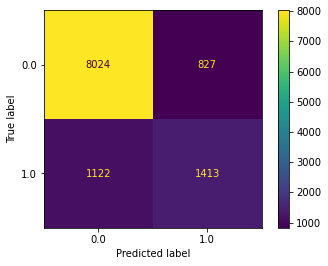

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_holdout, pipe.predict(X_holdout))
None

Como la mayoría de los modelos, es mejor para predecir los negativos, pero en este caso este modelo dio resultados levemente mejores en cuanto a los falsos negativos.

### Curva ROC

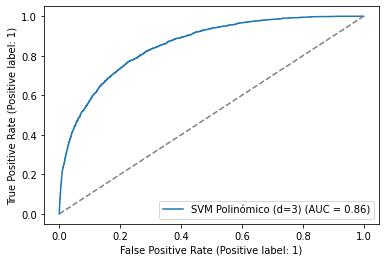

In [11]:
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(Y_holdout, pipe.predict_proba(X_holdout)[:,1], name = "SVM Polinómico (d=3)", ax = ax)
ax.plot([0, 1], [0, 1], "--", color="gray")
plt.show()